# SVM from scratch in Python using CVXOPT library.

In [5]:
import numpy as np
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles 
from sklearn.svm import SVC

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

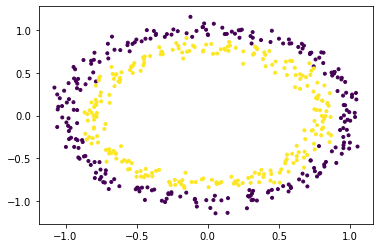

In [3]:
X, y = make_circles(n_samples = 500, noise = 0.05)
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.')  
plt.show()

In [4]:
class SVM(object):
    def __init__(self, C=10, kernel='linear', sigma=1, p=3, progress = False):
        self.C = C
        self.kernel = kernel
        self.sigma = sigma
        self.p = p
        self.progress = progress
    
    def y_transform(self,y):
        y_tran = np.zeros(y.size)
        self.class1 = np.unique(y)
        for i,j in enumerate(y):
            if j == self.class1[0]:
                y_tran[i]=-1
            if j == self.class1[1]:
                y_tran[i]=1
        y_tran = y_tran.reshape(-1,1) * 1.
        return y_tran
    
    def fit(self,X,y):
        m,n = X.shape
        self.K = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                if self.kernel == 'linear':
                    self.K[i,j] = self.linear_kernel(X[i], X[j])
                elif self.kernel == 'polynomial':
                    self.K[i,j] = self.polynomial_kernel(X[i], X[j],self.p)
                elif self.kernel == 'gaussian':
                    self.K[i,j] = self.gaussian_kernel(X[i], X[j],self.sigma)
        y = self.y_transform(y)
        
        #Converting into cvxopt format
        P = cvxopt_matrix(np.outer(y,y)*self.K)
        q = cvxopt_matrix(-np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt_matrix(y.reshape(1, -1))
        b = cvxopt_matrix(np.zeros(1))
        
        #Setting solver parameters (change default to decrease tolerance) 
        cvxopt_solvers.options['show_progress'] = self.progress
        #cvxopt_solvers.options['abstol'] = 1e-10
        #cvxopt_solvers.options['reltol'] = 1e-10
        #cvxopt_solvers.options['feastol'] = 1e-10
        
        sol = cvxopt_solvers.qp(P, q, G, h, A, b)
        a = np.array(sol['x'])
        
        sv = a > 1e-5
        ind = np.arange(len(a)).reshape(-1,1)[sv]
        a = a[sv]
        self.sv_x = np.vstack((X[:,0].reshape(-1,1)[sv],X[:,1].reshape(-1,1)[sv])).T
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(a), m))
        
        self.b = 0
        for n in range(len(a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(a * self.sv_y * self.K[ind[n],:].reshape(-1,1)[sv])
        if len(a)!=0:
            self.b /= len(a)
        self.a = a
    
    def support_vector(self):
        return self.sv_x
    
    def y_predict(self,X):
        y_predict = np.zeros(len(X))
        for q in range(len(X)):
            s = 0
            for i, j, k in zip(self.a, self.sv_y, self.sv_x):
                if self.kernel == 'linear':
                    s += i * j * self.linear_kernel(X[q], k)
                elif self.kernel == 'polynomial':
                    s += i * j * self.polynomial_kernel(X[q], k, self.p)
                elif self.kernel == 'gaussian':
                    s += i * j * self.gaussian_kernel(X[q], k, self.sigma)
            y_predict[q] = s
        return (y_predict + self.b)
    
    def predict(self,X):
        y = np.sign(self.y_predict(X))
        for i,j in enumerate(y):
            if j == -1:
                y[i]=self.class1[0]
            if j == 1:
                y[i]=self.class1[1]
        return y
    
    
    def linear_kernel(self,x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self,x, y, p):
        return (1 + np.dot(x, y)) ** p

    def gaussian_kernel(self,x, y, sigma):
        return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [39]:
button = widgets.Button(
    description='Plot',
)
@button.on_click
def plot_on_click(b):
    print("s")
button

Button(description='Plot', style=ButtonStyle())

s


In [7]:
from IPython.display import display, clear_output
caption = widgets.Label(value='The values of range1 and range2 are synchronized')
slider = widgets.Dropdown(options=['1', '2', '3'],value='2',description='Number:',disabled=False)

def handle_slider_change(change):
    if change.new == '1':
        clear_output()
        display(widgets.FloatLogSlider(min=-3,max=4,step=1,description='p'))
        button = widgets.Button(
            description='Plot',)
        @button.on_click
        def plot_on_click(b):
            plt.scatter([1,2], [2,1]) 
        display(button)
    if change.new == '3':
        display(widgets.FloatLogSlider(min=-3,max=4,step=1,description='p'))

slider.observe(handle_slider_change, names='value')

display(caption, slider)

FloatLogSlider(value=1.0, description='p', min=-3.0, step=1.0)

Button(description='Plot', style=ButtonStyle())

In [47]:
@interact_manual
def interact_option(kernel=['linear', 'polynomial', 'gaussian'], C=widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)):
    

#svm = SVM(kernel='linear')
#svm.fit(X,y)
#pred = svm.predict(X)

interactive(children=(Dropdown(description='kernel', options=('linear', 'polynomial', 'gaussian'), value='line…

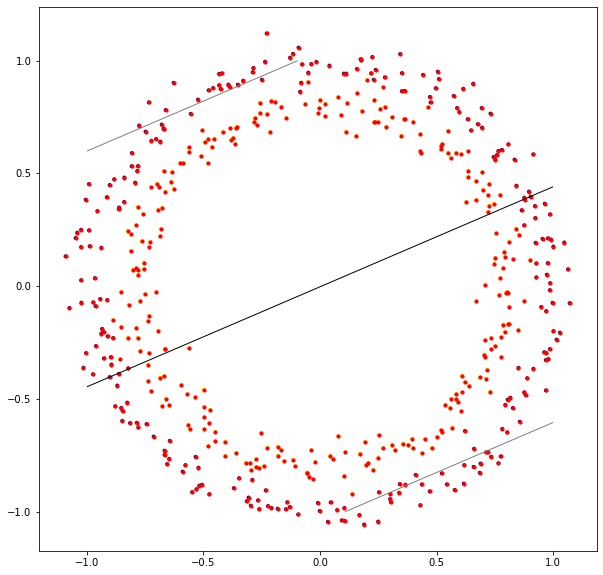

In [8]:
fig = plt.figure(figsize = (10,10))
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.') 
plt.scatter(svm.support_vector()[:,0], svm.support_vector()[:,1], s=10, c="r")

XX1, XX2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
XX = np.array([[x1, x2] for x1, x2 in zip(np.ravel(XX1), np.ravel(XX2))])
Z = svm.y_predict(XX).reshape(XX1.shape)
plt.contour(XX1, XX2, Z, [0.0], colors='k', linewidths=1, origin='lower')
plt.contour(XX1, XX2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
plt.contour(XX1, XX2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

plt.axis("tight")
plt.show()

73 support vectors out of 500 points


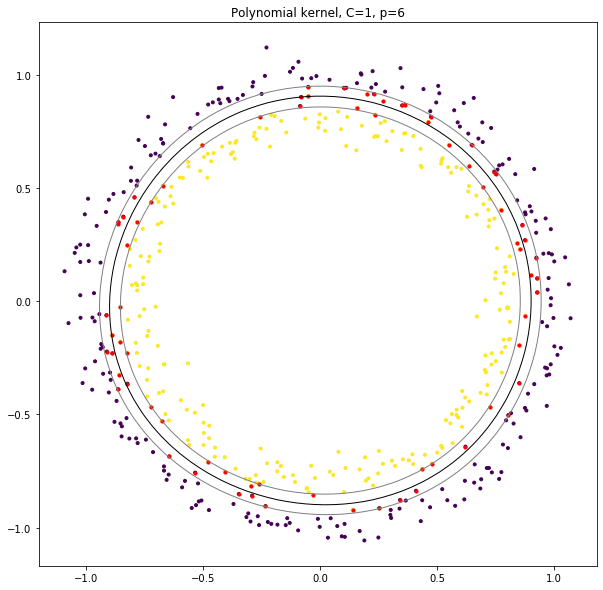

In [25]:
svm = SVM(kernel='polynomial',C=1,p=4)
svm.fit(X,y)
#pred = svm.predict(X)

fig = plt.figure(figsize = (10,10))
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.') 
plt.scatter(svm.support_vector()[:,0], svm.support_vector()[:,1], s=10, c="r")

XX1, XX2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
XX = np.array([[x1, x2] for x1, x2 in zip(np.ravel(XX1), np.ravel(XX2))])
Z = svm.y_predict(XX).reshape(XX1.shape)
plt.contour(XX1, XX2, Z, [0.0], colors='k', linewidths=1, origin='lower')
plt.contour(XX1, XX2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
plt.contour(XX1, XX2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
plt.title("v")
plt.title("Polynomial kernel, C=1, p=6")
plt.axis("tight")
plt.show()

97 support vectors out of 500 points


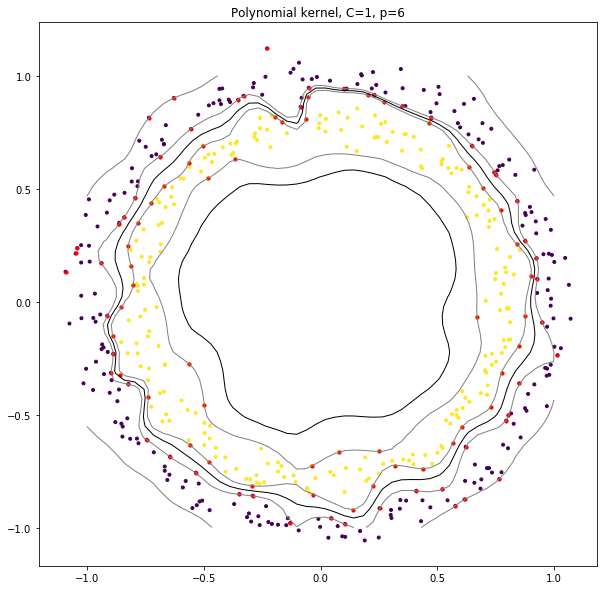

In [32]:
svm = SVM(kernel='gaussian',C=100,sigma=0.1)
svm.fit(X,y)
#pred = svm.predict(X)

fig = plt.figure(figsize = (10,10))
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.') 
plt.scatter(svm.support_vector()[:,0], svm.support_vector()[:,1], s=10, c="r")

XX1, XX2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
XX = np.array([[x1, x2] for x1, x2 in zip(np.ravel(XX1), np.ravel(XX2))])
Z = svm.y_predict(XX).reshape(XX1.shape)
plt.contour(XX1, XX2, Z, [0.0], colors='k', linewidths=1, origin='lower')
plt.contour(XX1, XX2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
plt.contour(XX1, XX2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
plt.title("v")
plt.title("Polynomial kernel, C=1, p=6")
plt.axis("tight")
plt.show()

Testing with sklearn library

c:\users\divay sharma\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


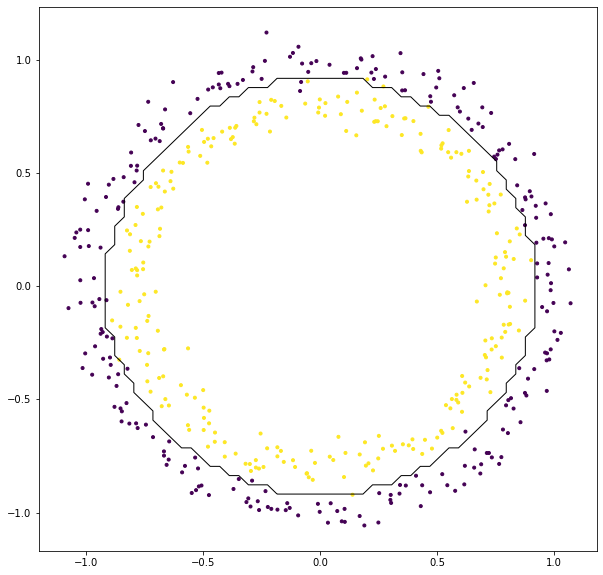

In [27]:
clf = SVC(C = 10, kernel = 'rbf')
clf.fit(X, y) 
fig = plt.figure(figsize = (10,10))
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.') 

XX1, XX2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
XX = np.array([[x1, x2] for x1, x2 in zip(np.ravel(XX1), np.ravel(XX2))])
Z = clf.predict(XX).reshape(XX1.shape)
plt.contour(XX1, XX2, Z, [0.0], colors='k', linewidths=1, origin='lower')

plt.axis("tight")
plt.show()